In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

#from pytoch_model_summary import summary

In [5]:
!pip install einops

In [6]:
import einops

# Dataset

In [2]:
class Digits(Dataset):
    
    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)
        self.transforms = transforms
    def __len__(self):
        return len(self.data)
      def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

# ARM Model

In [3]:
class CasualConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
               dilation, A=False, **kwargs):
        super().__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A
        self.padding = (kernel_size - 1) * dilation + A*1
        self.conv1d = nn.Conv1d(in_channels, out_channels,
                                kernel_size=self.kernel_size, dilation=dilation,
                               padding=0, stride=1)
    def forward(self, x):
        x = F.pad(x,(self.padding,0))
        conv1d_out = self.conv1d(x)
        if self.A:
            return conv1d_out[:,:,:-1]
        else:
            return conv1d_out
    

In [54]:
class ARM(nn.Module):
    def __init__(self, net, D=2, num_vals=256, device='cuda'):
        super().__init__()
        self.net = net
        self.num_vals = num_vals
        self.D = D
        self.device = device
    def prob(self, h):
        p = einops.rearrange(h,'n c d -> n d c')
        p = F.softmax(p, dim=2) # dim (N, D, C) - 
        return p
    def forward(self, x):
        h = self.net(x.unsqueeze(1)) # x - shape (N, 1, D)
        return h # h - shape (N, num_vals, D)
    def sample(self, batch_size):
        x_new = torch.zeros((batch_size, self.D)).to(self.device)
        for d in range(self.D):
            h = self.forward(x_new)
            p = self.prob(h)
            x_new_d = torch.multinomial(p[:,d,:], num_samples=1)
            x_new[:,d] = x_new_d[:,0]
        return x_new

# Auxiliary functions: training, evaluation, plotting

In [35]:
def evaluation(test_loader, criterion, name=None, model_best=None, epoch=None, device="cuda"):
    if model_best is None:
        model_best = torch.load(name+".model")
    model_best.eval()
    loss = 0.
    N = 0.
    for idx_batch, test_batch in enumerate(test_loader):
        test_batch = test_batch.to(device)
        output = model_best(test_batch)
        target = test_batch.clone().detach().to(torch.int64)
        loss_t = criterion(output, target)
        loss += loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N
    if epoch is None:
        print(f"FINAL LOSS: nll={loss}")
    else:
        print(f"Epoch: {epoch}, val nll={loss}")
    return loss

In [47]:
def samples_real(test_loader):
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottabla_image = np.reshape(x[i],(8,8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis("off")
def sample_generated(model, data_loader, extra_name=''):
    #x = next(iter(data_loader)).detach().numpy()
    model.eval()
    num_x = 4
    num_y = 4
    x = model.sample(num_x * num_y)
    x = x.detach().cpu().numpy()
    
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

In [14]:
def plot_curve(nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')

In [38]:
def training(model, max_patience, criterion, num_epochs, optimizer, training_loader, val_loader, device="cuda"):
    nll_val = []
    best_nll = 1000.
    patience = 0
    for e in range(num_epochs):
        model.train()
        for idx_batch, batch in enumerate(training_loader):
            batch = batch.to("cuda")
            output = model(batch)
            target = batch.clone().detach().to(torch.int64)
            loss = criterion(output, target)
            
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        # validation
        loss_val = evaluation(val_loader, criterion=criterion, model_best=model, epoch=e)
        nll_val.append(loss_val)
        
        if e == 0:
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                best_nll = loss_val
                patience = 0
                sample_generated(model, val_loader)
            else:
                patience = patience + 1
        if patience > max_patience:
            break
    nll_val = np.asarray(nll_val)
    return nll_val

In [30]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'arm'

# Hyperparameters

In [62]:
D = 64
M = 256
lr = 1e-4
num_epochs = 1000
max_patience = 20

# ARM Model

In [63]:
likelihood_type = 'categorical'
num_vals = 17
kernel = 7

net = nn.Sequential(
    CasualConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, A=True),
    nn.LeakyReLU(),
    CasualConv1d(in_channels=M, out_channels=M, dilation=2, kernel_size=kernel, A=False),
    nn.LeakyReLU(),
    CasualConv1d(in_channels=M, out_channels=M, dilation=4, kernel_size=kernel, A=False),
    nn.LeakyReLU(),
    CasualConv1d(in_channels=M, out_channels=M, dilation=8, kernel_size=kernel, A=False),
    nn.LeakyReLU(),
    CasualConv1d(in_channels=M, out_channels=M, dilation=8, kernel_size=kernel, A=False),
    nn.LeakyReLU(),
    CasualConv1d(in_channels=M, out_channels=M, dilation=8, kernel_size=kernel, A=False),
    nn.LeakyReLU(),
    CasualConv1d(in_channels=M, out_channels=num_vals, dilation=1, kernel_size=kernel, A=False))
model =ARM(net, D=D, num_vals=num_vals)
model.to("cuda")

ARM(
  (net): Sequential(
    (0): CasualConv1d(
      (conv1d): Conv1d(1, 256, kernel_size=(7,), stride=(1,))
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): CasualConv1d(
      (conv1d): Conv1d(256, 256, kernel_size=(7,), stride=(1,), dilation=(2,))
    )
    (3): LeakyReLU(negative_slope=0.01)
    (4): CasualConv1d(
      (conv1d): Conv1d(256, 256, kernel_size=(7,), stride=(1,), dilation=(4,))
    )
    (5): LeakyReLU(negative_slope=0.01)
    (6): CasualConv1d(
      (conv1d): Conv1d(256, 256, kernel_size=(7,), stride=(1,), dilation=(8,))
    )
    (7): LeakyReLU(negative_slope=0.01)
    (8): CasualConv1d(
      (conv1d): Conv1d(256, 256, kernel_size=(7,), stride=(1,), dilation=(8,))
    )
    (9): LeakyReLU(negative_slope=0.01)
    (10): CasualConv1d(
      (conv1d): Conv1d(256, 256, kernel_size=(7,), stride=(1,), dilation=(8,))
    )
    (11): LeakyReLU(negative_slope=0.01)
    (12): CasualConv1d(
      (conv1d): Conv1d(256, 17, kernel_size=(7,), stride=(1,))
    )
  )
)

In [64]:
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad==True], lr=lr)
criterion = nn.CrossEntropyLoss()

Epoch: 0, val nll=0.041496293204171315
Epoch: 1, val nll=0.03668030330113002
Epoch: 2, val nll=0.03430798155920846
Epoch: 3, val nll=0.03294886554990496
Epoch: 4, val nll=0.032003647940499445
Epoch: 5, val nll=0.031363513810294015
Epoch: 6, val nll=0.03048552989959717
Epoch: 7, val nll=0.029700279576437814
Epoch: 8, val nll=0.029073984282357353
Epoch: 9, val nll=0.028586976868765695
Epoch: 10, val nll=0.028127410411834718
Epoch: 11, val nll=0.027824254376547678
Epoch: 12, val nll=0.027696566581726076
Epoch: 13, val nll=0.02755171775817871
Epoch: 14, val nll=0.02741236993244716
Epoch: 15, val nll=0.027130519321986606
Epoch: 16, val nll=0.027098584856305803
Epoch: 17, val nll=0.02703617402485439
Epoch: 18, val nll=0.0268818085534232
Epoch: 19, val nll=0.026749746458871022
Epoch: 20, val nll=0.026862780366625105
Epoch: 21, val nll=0.026630499703543527
Epoch: 22, val nll=0.0265448488507952


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch: 23, val nll=0.026480011258806502
Epoch: 24, val nll=0.026470235075269428
Epoch: 25, val nll=0.02643634217126029
Epoch: 26, val nll=0.02632756573813302
Epoch: 27, val nll=0.026324653284890313
Epoch: 28, val nll=0.02631453037261963
Epoch: 29, val nll=0.026247874668666293
Epoch: 30, val nll=0.026214684077671597
Epoch: 31, val nll=0.026258819103240967
Epoch: 32, val nll=0.026117235251835413
Epoch: 33, val nll=0.026042816979544504
Epoch: 34, val nll=0.025988812787192207
Epoch: 35, val nll=0.025825930663517543
Epoch: 36, val nll=0.025827635015760148
Epoch: 37, val nll=0.025773753438677105
Epoch: 38, val nll=0.025538605621882846
Epoch: 39, val nll=0.025293608733585903
Epoch: 40, val nll=0.025266584668840682
Epoch: 41, val nll=0.02497640882219587
Epoch: 42, val nll=0.02506162234715053
Epoch: 43, val nll=0.025095605509621758
Epoch: 44, val nll=0.024945239339556013
Epoch: 45, val nll=0.025042190211159842
Epoch: 46, val nll=0.02496755770274571
Epoch: 47, val nll=0.024838672706059047
Epoch:

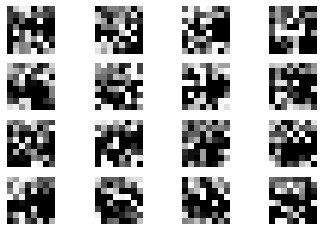

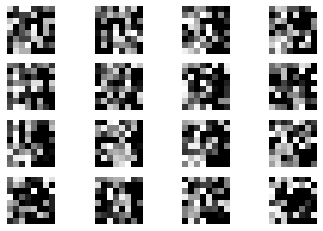

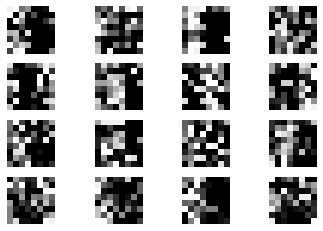

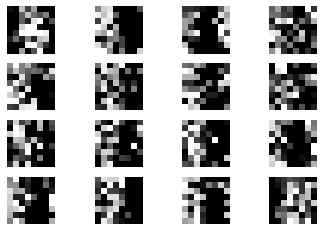

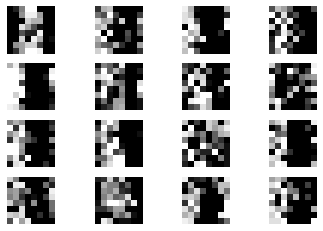

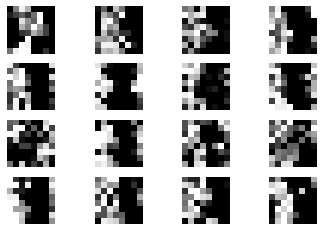

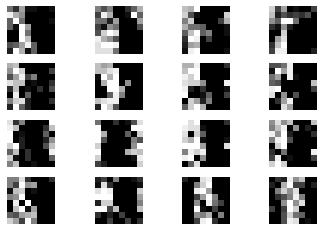

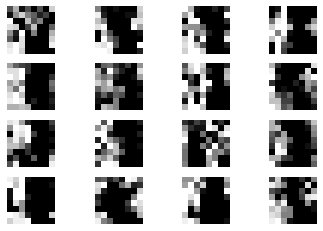

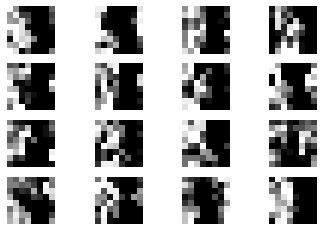

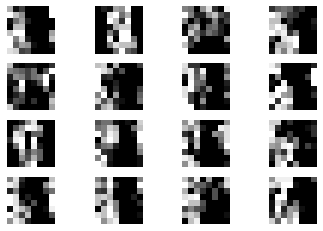

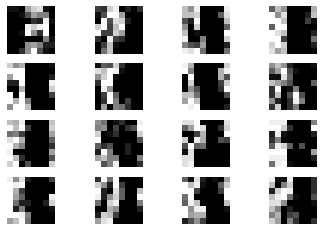

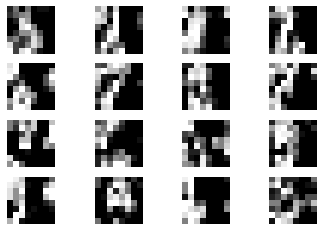

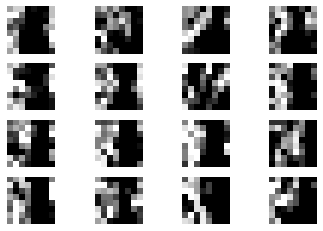

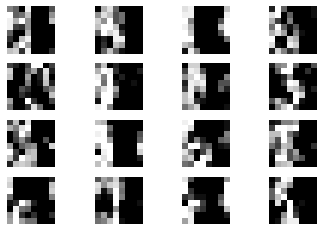

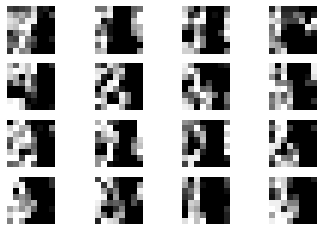

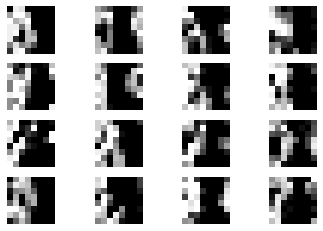

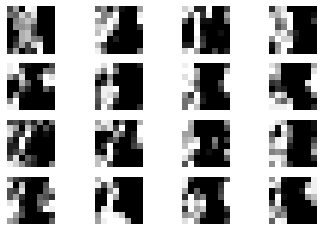

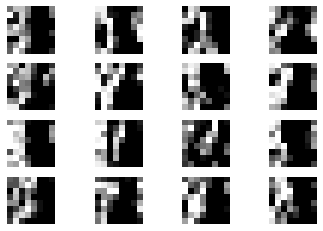

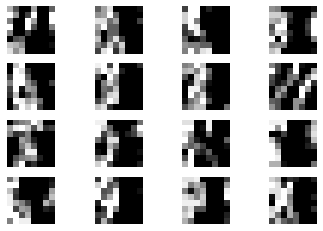

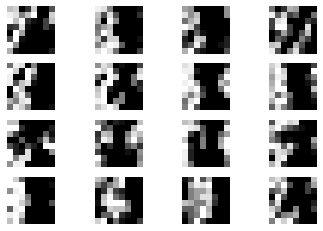

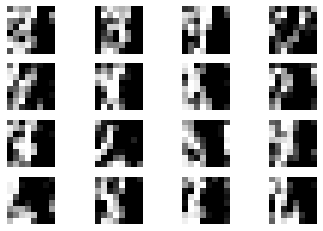

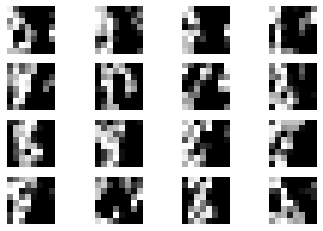

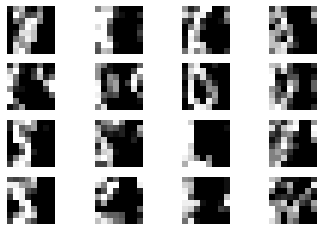

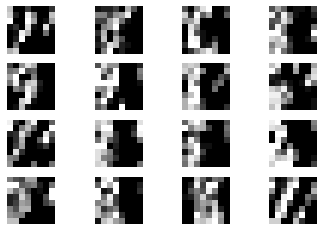

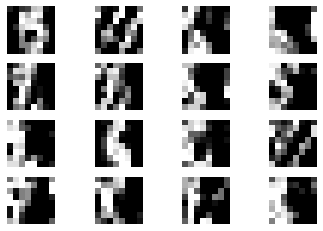

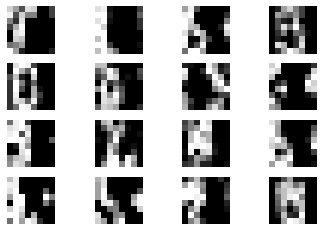

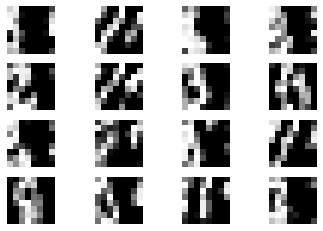

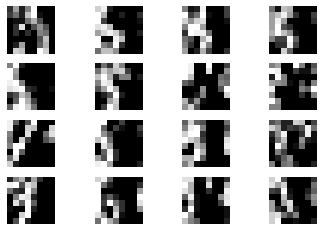

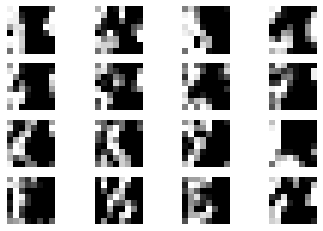

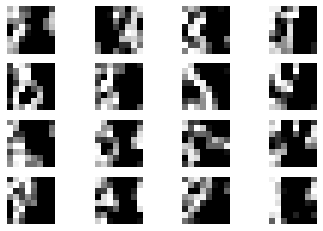

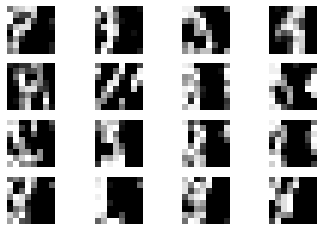

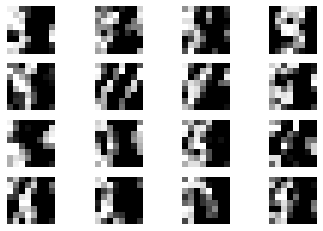

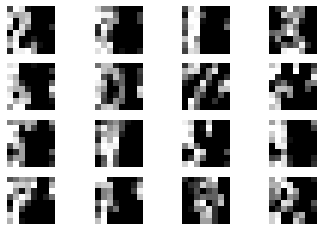

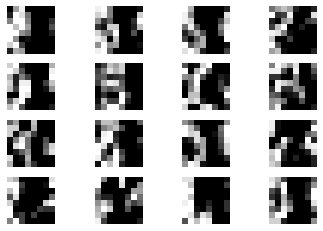

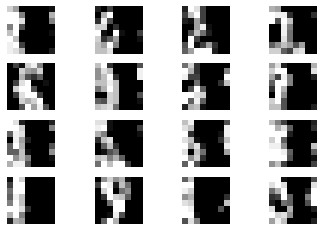

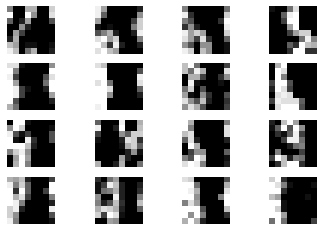

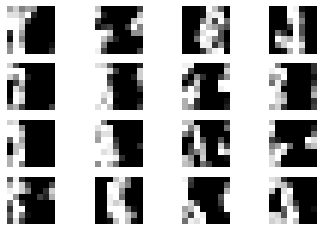

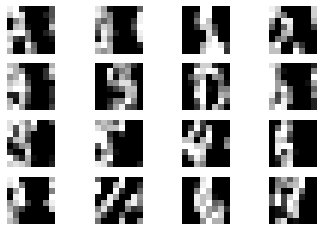

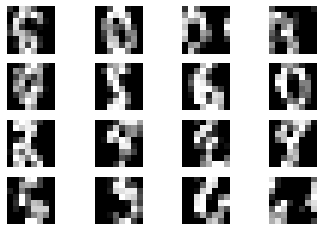

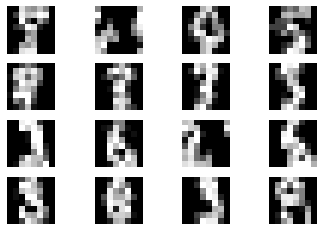

In [65]:
#training
nll_val = training(model, max_patience=max_patience, criterion=criterion, 
                   num_epochs=num_epochs, optimizer=optimizer, training_loader=training_loader, val_loader=val_loader)